In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras import Sequential, Input, Model, regularizers
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout, Dense, LSTM, Reshape, BatchNormalization, UpSampling1D
from tensorflow.train import AdamOptimizer
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

tf.enable_eager_execution()

In [14]:
INPUT_LENGTH = 5000
INPUT_THRESHOLD = 1000

NUM_CLASSES = 3


REGULAR = "reg"
CHIMERIC = "chi"
REPEAT = "rep"
LOW_QUALITY = "loq"


def create_1d_conv_model():
    model = Sequential()

    model.add(
        Reshape(target_shape=(INPUT_LENGTH, 1), input_shape=(INPUT_LENGTH,))
    )
    model.add(
        Conv1D(filters=128, kernel_size=23, activation='relu', input_shape=(INPUT_LENGTH, 1), padding="same")
    )
    model.add(
        Conv1D(filters=64, kernel_size=23, activation='relu')
    )
    model.add(
        MaxPooling1D(pool_size=5)
    )
    model.add(
        BatchNormalization()
    )
    model.add(
        Conv1D(filters=64, kernel_size=23, activation='relu')
    )
    model.add(
        Conv1D(filters=32, kernel_size=23, activation='relu')
    )
    model.add(
        MaxPooling1D(pool_size=5)
    )
    model.add(
        BatchNormalization()
    )
    model.add(
        Conv1D(filters=32, kernel_size=23, activation='relu')
    )
    model.add(
        Conv1D(filters=16, kernel_size=23, activation='relu')
    )
    model.add(
        GlobalAveragePooling1D()
    )
    model.add(
        Dense(units=NUM_CLASSES, activation='softmax')
    )

    print(model.summary())

    model.compile(optimizer=AdamOptimizer(learning_rate=0.0001), loss='categorical_crossentropy')
    
    return model

In [15]:
def create_datasets(tsv_input):
    data = pd.read_csv(tsv_input, delimiter="\t")

    # Filter out all low quality reads
    data = data.loc[data.CAT != LOW_QUALITY]

    # Convert sequence string to float array
    data.PTS = data.PTS.apply(string_to_array)

    # Convert labels from strings to ints
    ys = data.CAT.apply(category_to_int).to_numpy()
    xs = np.stack(data.PTS.array)

    encoded_ys = to_categorical(ys, num_classes=NUM_CLASSES)

    print("XS shape: {}".format(xs.shape))
    print("One-hot encoded YS shape: {}".format(encoded_ys.shape))

    train_x, test_x, train_y, test_y = train_test_split(xs, encoded_ys, test_size=0.3)

    return train_x, train_y, test_x, test_y


def string_to_array(data):
    data_string = str(data)
    split = data_string.split(',')

    return np.array([float(i) for i in split])


def category_to_int(data):
    category = str(data)
    if category == REGULAR:
        return 0
    elif category == REPEAT:
        return 1
    else:
        return 2


def evaluate(epochs_num=30):
    model = create_1d_conv_model()

    train_x, train_y, test_x, test_y = create_datasets("/floyd/input/overlaps/categorized_400.tsv")
    train_x = train_x / np.max(train_x)
    test_x = test_x / np.max(test_x)

    # patient early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    cp = ModelCheckpoint(filepath="cnn.h5", save_best_only=True, verbose=0)

    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=64,
        epochs=epochs_num,
        validation_data=(test_x, test_y),
        callbacks=[es, cp]
    )
    plot_loss(history, epochs_num)

    pred_y = model.predict(test_x)
    matrix = metrics.confusion_matrix(test_y.argmax(axis=1), pred_y.argmax(axis=1))

    print(metrics.classification_report(test_y.argmax(axis=1), pred_y.argmax(axis=1)))
    plot_confusion_matrix(matrix)
    

def plot_loss(model, epochs_num):
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    epochs = range(1, epochs_num + 1)
    plt.figure()
    plt.plot(epochs, loss, 'r-', label='Training loss')
    plt.plot(epochs, val_loss, 'b-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot_confusion_matrix(matrix):
    df_cm = pd.DataFrame(matrix, ["regular", "repeat", "chimeric"], ["regular", "repeat", "chimeric"])
    plt.figure(figsize=(10, 7))
    sb.heatmap(df_cm, annot=True)
    plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 5000, 1)           0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 5000, 128)         3072      
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 4978, 64)          188480    
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 995, 64)           0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 995, 64)           256       
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 973, 64)           94272     
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 951, 32)           47136     
__________

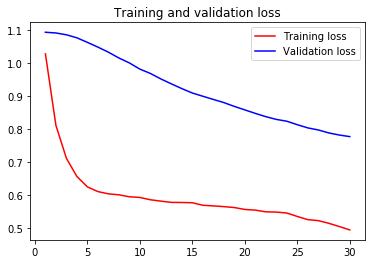

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00        27
          1       0.71      1.00      0.83        70
          2       0.00      0.00      0.00         2

avg / total       0.50      0.71      0.59        99



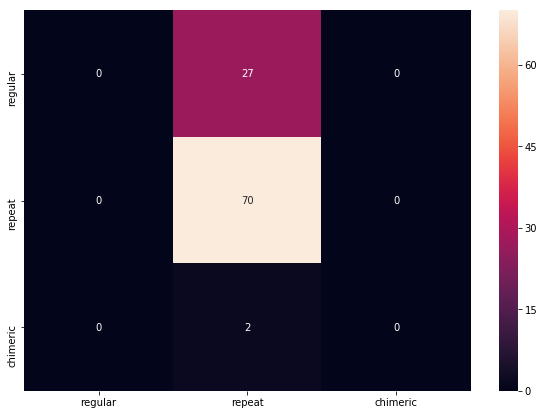

In [16]:
evaluate()